# Chapter 2: ML Models for Vision

### Factors Making the 5-Flowers Dataset Suboptimal

#### Quantity

- ML models typically require millions of images for training from scratch.
- While there are alternative approaches that can work with fewer images, it's recommended to collect the largest dataset that's practically and ethically possible.

#### Data Format

- Storing images as individual JPEG files is inefficient, as most training time is spent on data reading.
- TensorFlow Record format is recommended for efficiency.

#### Content

- The 5-Flowers dataset consists of found data or images not explicitly collected for the classification task.
- Purposeful data collection should be employed, if allowed by the problem domain.

#### Labeling

- This dataset was manually labeled, which can become impractical for larger datasets.
- Labeling of images is a broad topic and needs careful consideration.

### NOTE:
- your training dataset has to reflect the conditions under which your model will be required to make predictions

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.1
Found GPU at: /device:GPU:0


2023-07-31 14:50:36.761860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 14:50:36.762141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 14:50:36.762324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

/bin/bash: /home/kprasath/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: gsutil: command not found



NOTES:

- img variable is a tensor, array of bytes
- parse bytes and convert into pixel data (decoding)
- specify RGB chanel in decode
- opacity is the 4th channel
- the channels available depends on the stored file
- pixels consist of RGB [0,255]
- so we convert to float and bound [0,1]
- cuz ML optimizers are tuned to work better with smaller numbers
- resize to standardise 
- becuz ML models are built to work with inputs of known size

- all numpy arithmetic is done on the CPU, while the TensorFlow code runs on a GPU if one is available
- also more efficient if you vectorise your code to process batches of images

- A layer is a Keras component that takes a tensor as input, applies some TensorFlow operations to that input, and outputs a tensor

- The Flatten layer is connected to a Dense layer with one output node for each class

- The name Dense means that every output is a weighted sum of every input and no weights are shared

In [10]:


import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3


def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


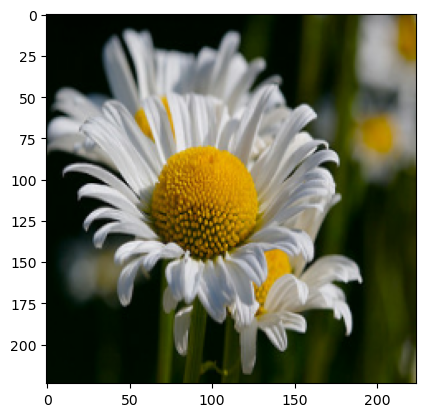

In [12]:
# Try reading and displaying one of the files
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow((img.numpy()));

show_image(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


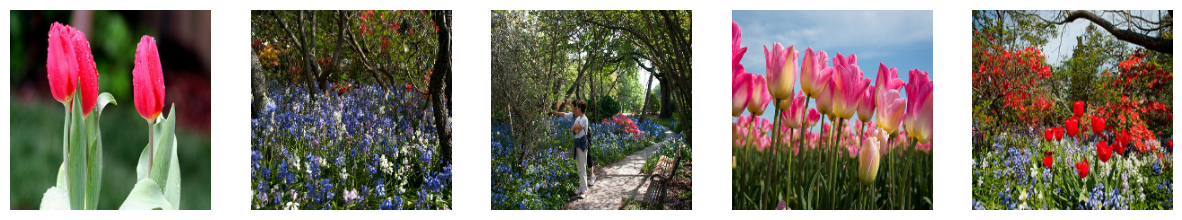

In [13]:
# notice that the file name has the flower type in it. Let's look at a few tulips
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/*.jpg")

f, ax = plt.subplots(1, 5, figsize=(15,15))

for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

In [14]:
tf.strings.split(tf.strings.regex_replace(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", ""),
    '/')[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

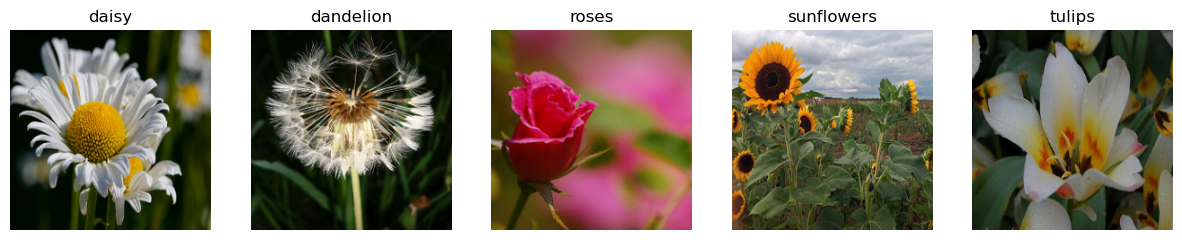

In [15]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].axis('off')

In [ ]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  # label = tf.math.equal(CLASS_NAMES, label_string)
  return img, label_string

dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv))

for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) # average pixel in the image
  print(label, avg)

In [16]:
# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(10)

# linear model
model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)


In [ ]:
class Centroid:
  def __init__(self, label):
    self.label = label
    self.sum_so_far = tf.constant(0., dtype=tf.float32)
    self.count_so_far = 0
  
  def update(self, value):
    self.sum_so_far = self.sum_so_far + value
    self.count_so_far = self.count_so_far + 1
    if self.count_so_far%100 == 0:
      print(self.label, self.count_so_far)

  def centroid(self):
    return self.sum_so_far / self.count_so_far

  def __str__(self):
    return '{} {}'.format(self.label, self.centroid().numpy())


class CentroidRule:
  def __init__(self):
    self.centroids = {
        f: Centroid(f) for f in CLASS_NAMES}

  def fit(self, dataset):
    for img, label in dataset:
      label = label.numpy().decode("utf-8")
      avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
      self.centroids[label].update(avg)
  
  def predict(self, img):
    avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
    best_label = ""
    best_diff = 999
    for key, val in self.centroids.items():
      diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
      if diff < best_diff:
        best_diff = best_diff
        best_label = key
    return best_label
  
  def evaluate(self, dataset):
    num_correct, total_images = 0, 0
    for img, label in dataset:
      correct = label.numpy().decode('utf-8')
      predicted = self.predict(img)
      if correct == predicted:
        num_correct = num_correct + 1
      total_images = total_images + 1
    accuracy = num_correct / total_images
    return(accuracy)

In [ ]:
rule = CentroidRule()

# to try it on the full dataset, remove the .take(500)
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).take(500)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).take(50)

rule.fit(train_dataset)

# There is not much separation between the classes
print(rule.centroids['daisy'])
print(rule.centroids['roses'])

# let's evaluate it
rule.evaluate(eval_dataset)